In [1]:
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi

DATASET_DIR = Path.cwd() / "datasets" / "dataturks"
DATASET_PATH = DATASET_DIR / "Entity Recognition in Resumes.json"

if DATASET_DIR.exists():
    print("Dataset already loaded")
else:
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files('dataturks/resume-entities-for-ner', path=DATASET_DIR, quiet=False, unzip=True)

Dataset already loaded


In [2]:
import json
import pandas as pd
from collections import defaultdict



with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    resumes_data = [json.loads(f_line) for f_line in f]
   

df = pd.DataFrame(resumes_data)
df

,content,annotation,extras
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...",None
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...",None
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...",None
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...",None
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...",None
...,...,...,...
215,"Mansi Thanki\nStudent\n\nJamnagar, Gujarat - E...","[{'label': ['College Name'], 'points': [{'star...",None
216,Anil Kumar\nMicrosoft Azure (Basic Management)...,"[{'label': ['Location'], 'points': [{'start': ...",None
217,Siddharth Choudhary\nMicrosoft Office Suite - ...,"[{'label': ['Skills'], 'points': [{'start': 78...",None
218,Valarmathi Dhandapani\nInvestment Banking Oper...,"[{'label': ['Skills'], 'points': [{'start': 92...",None


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

def load_and_analyze_resumes(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    
    print(f"Всего резюме: {len(data)}")
    return data

resumes_data = load_and_analyze_resumes(DATASET_PATH)

print("\n=== СТРУКТУРА ОДНОГО РЕЗЮМЕ ===")
first_resume = resumes_data[0]
print(f"Ключи: {list(first_resume.keys())}")
print(f"Количество аннотаций: {len(first_resume['annotation'])}")
print(f"Длина текста: {len(first_resume['content'])} символов")

print("\nПример аннотации:")
print(json.dumps(first_resume['annotation'][0], indent=2))

Всего резюме: 220

=== СТРУКТУРА ОДНОГО РЕЗЮМЕ ===
Ключи: ['content', 'annotation', 'extras']
Количество аннотаций: 14
Длина текста: 1622 символов

Пример аннотации:
{
  "label": [
    "Skills"
  ],
  "points": [
    {
      "start": 1295,
      "end": 1621,
      "text": "\n\u2022 Programming language: C, C++, Java\n\u2022 Oracle PeopleSoft\n\u2022 Internet Of Things\n\u2022 Machine Learning\n\u2022 Database Management System\n\u2022 Computer Networks\n\u2022 Operating System worked on: Linux, Windows, Mac\n\nNon - Technical Skills\n\n\u2022 Honest and Hard-Working\n\u2022 Tolerant and Flexible to Different Situations\n\u2022 Polite and Calm\n\u2022 Team-Player"
    }
  ]
}


Пропущено аннотаций с пустыми labels: 2
=== ОСНОВНАЯ СТАТИСТИКА СУЩНОСТЕЙ ===
Всего сущностей: 3556
Уникальных типов сущностей: 11
Уникальных текстов сущностей: 1745


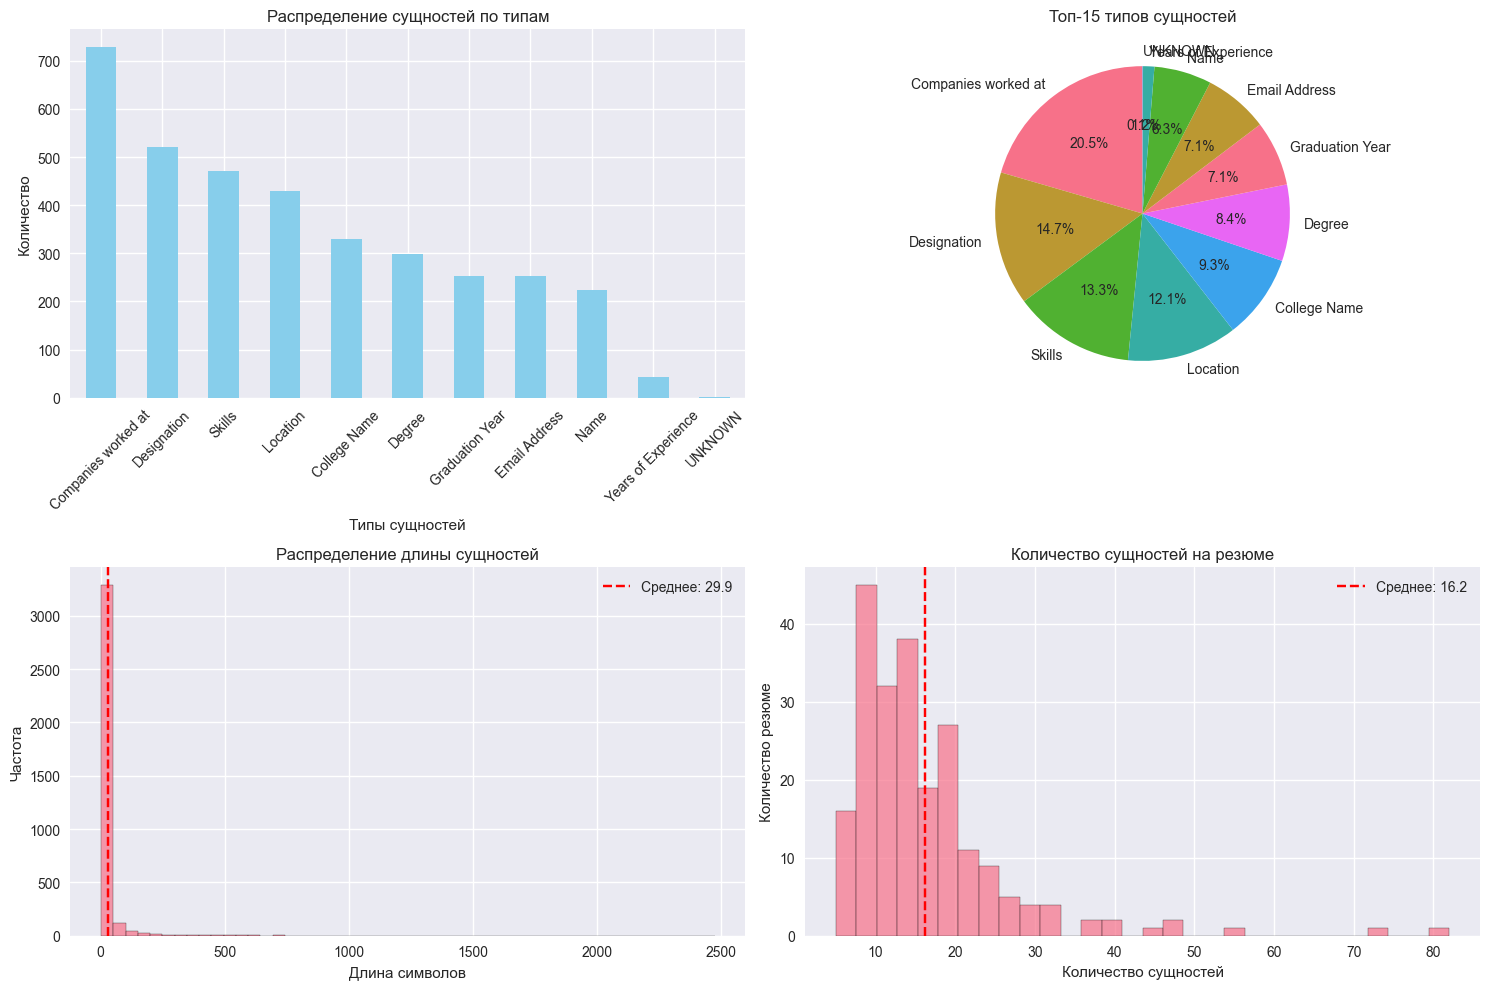


Среднее количество сущностей на резюме: 16.16
Медианное количество сущностей на резюме: 13.00


In [4]:
def analyze_entities(resumes_data):
    all_entities = []
    entity_stats = {}
    skipped_annotations = 0
    
    for resume in resumes_data:
        for annotation in resume['annotation']:
            if not annotation['label']:
                skipped_annotations += 1
                continue
                
            label = annotation['label'][0]
            text = annotation['points'][0]['text']
            start = annotation['points'][0]['start']
            end = annotation['points'][0]['end']
            
            all_entities.append({
                'label': label,
                'text': text.strip(),
                'length': len(text.strip()),
                'resume_length': len(resume['content'])
            })
            
            if label not in entity_stats:
                entity_stats[label] = []
            entity_stats[label].append(text.strip())
    
    print(f"Пропущено аннотаций с пустыми labels: {skipped_annotations}")
    return pd.DataFrame(all_entities), entity_stats

entities_df, entity_stats = analyze_entities(resumes_data)

print("=== ОСНОВНАЯ СТАТИСТИКА СУЩНОСТЕЙ ===")
print(f"Всего сущностей: {len(entities_df)}")
print(f"Уникальных типов сущностей: {entities_df['label'].nunique()}")
print(f"Уникальных текстов сущностей: {entities_df['text'].nunique()}")

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
label_counts = entities_df['label'].value_counts()
label_counts.plot(kind='bar', color='skyblue')
plt.title('Распределение сущностей по типам')
plt.xlabel('Типы сущностей')
plt.ylabel('Количество')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)

top_15 = label_counts.head(15)
plt.pie(top_15.values, labels=top_15.index, autopct='%1.1f%%', startangle=90)
plt.title('Топ-15 типов сущностей')

plt.subplot(2, 2, 3)

plt.hist(entities_df['length'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(entities_df['length'].mean(), color='red', linestyle='--', 
            label=f'Среднее: {entities_df["length"].mean():.1f}')
plt.title('Распределение длины сущностей')
plt.xlabel('Длина символов')
plt.ylabel('Частота')
plt.legend()

plt.subplot(2, 2, 4)

entities_per_resume = [len([ann for ann in resume['annotation'] if ann['label']]) for resume in resumes_data]
plt.hist(entities_per_resume, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(entities_per_resume), color='red', linestyle='--', 
            label=f'Среднее: {np.mean(entities_per_resume):.1f}')
plt.title('Количество сущностей на резюме')
plt.xlabel('Количество сущностей')
plt.ylabel('Количество резюме')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nСреднее количество сущностей на резюме: {np.mean(entities_per_resume):.2f}")
print(f"Медианное количество сущностей на резюме: {np.median(entities_per_resume):.2f}")

=== ДЕТАЛЬНЫЙ АНАЛИЗ ПО ТИПАМ СУЩНОСТЕЙ ===


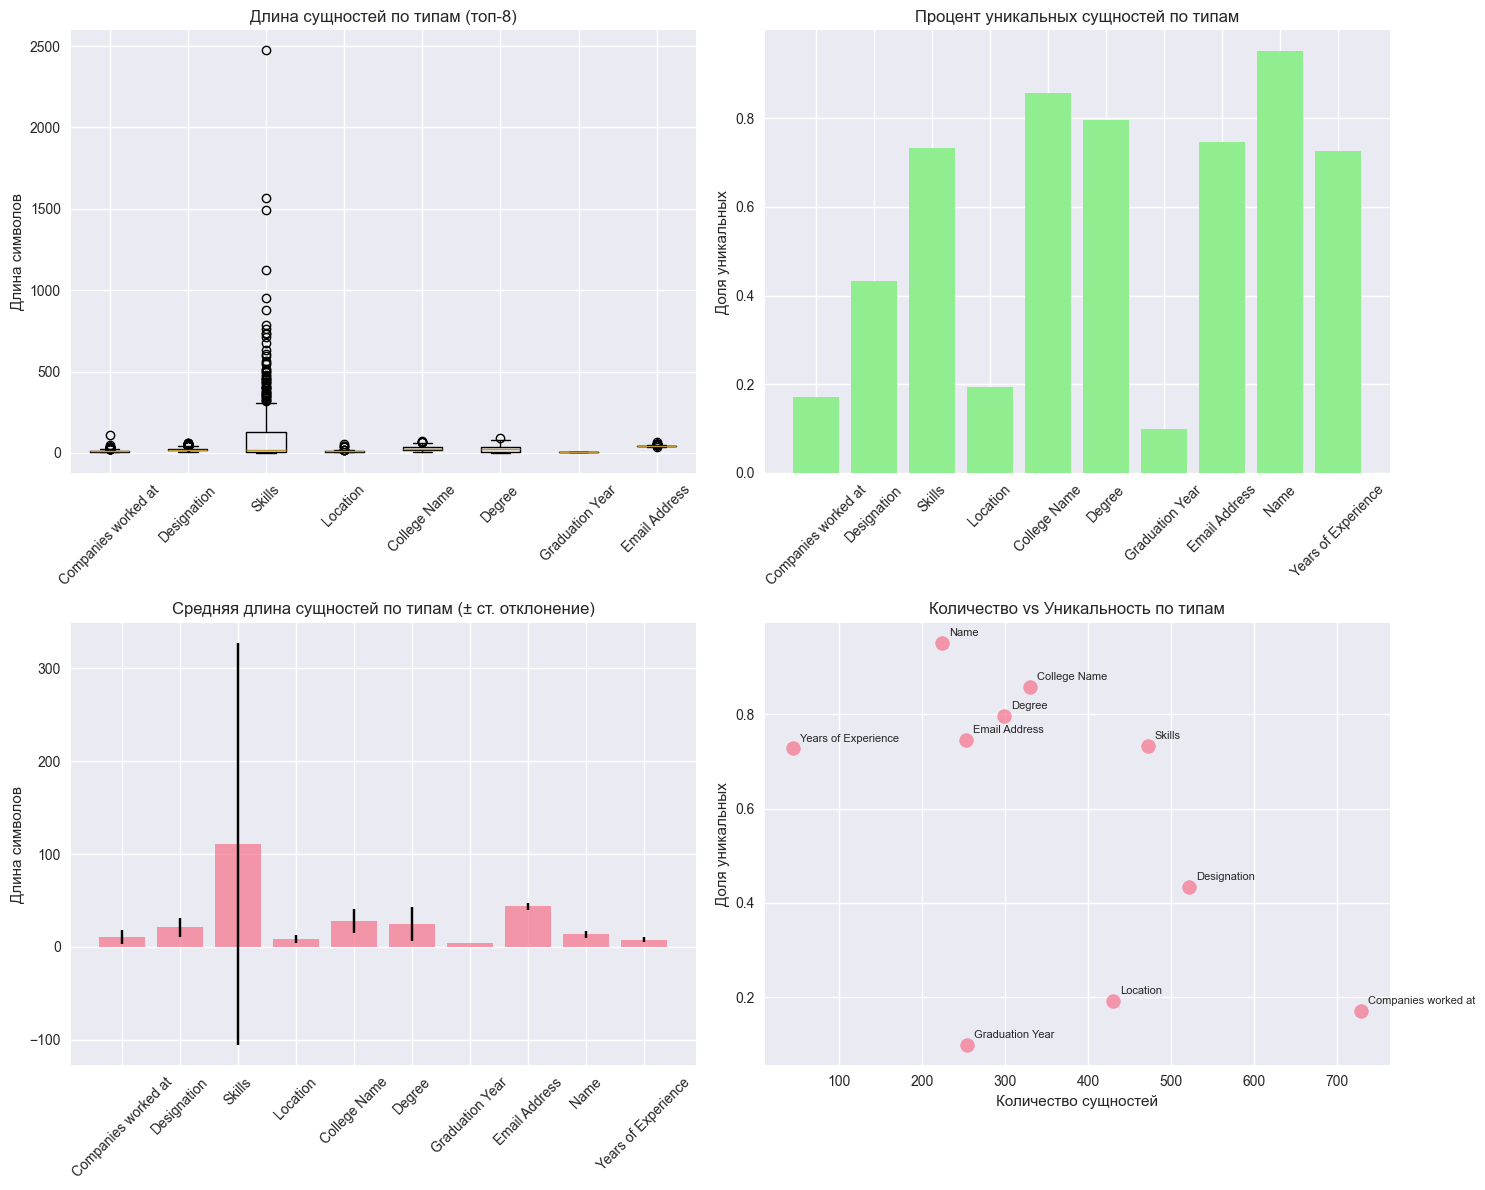

In [5]:
print("=== ДЕТАЛЬНЫЙ АНАЛИЗ ПО ТИПАМ СУЩНОСТЕЙ ===")

top_labels = entities_df['label'].value_counts().head(10).index

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

top_8_labels = top_labels[:8]
lengths_data = [entities_df[entities_df['label'] == label]['length'] for label in top_8_labels]
axes[0,0].boxplot(lengths_data, labels=top_8_labels)
axes[0,0].set_title('Длина сущностей по типам (топ-8)')
axes[0,0].set_ylabel('Длина символов')
plt.setp(axes[0,0].xaxis.get_majorticklabels(), rotation=45)

uniqueness_ratio = []
for label in top_labels:
    label_data = entities_df[entities_df['label'] == label]
    unique_ratio = label_data['text'].nunique() / len(label_data)
    uniqueness_ratio.append(unique_ratio)

axes[0,1].bar(range(len(top_labels)), uniqueness_ratio, color='lightgreen')
axes[0,1].set_xticks(range(len(top_labels)))
axes[0,1].set_xticklabels(top_labels, rotation=45)
axes[0,1].set_title('Процент уникальных сущностей по типам')
axes[0,1].set_ylabel('Доля уникальных')

stats_by_label = entities_df.groupby('label')['length'].agg(['mean', 'median', 'std']).loc[top_labels]
axes[1,0].bar(range(len(stats_by_label)), stats_by_label['mean'], 
              yerr=stats_by_label['std'], alpha=0.7, capsize=5)
axes[1,0].set_xticks(range(len(stats_by_label)))
axes[1,0].set_xticklabels(stats_by_label.index, rotation=45)
axes[1,0].set_title('Средняя длина сущностей по типам (± ст. отклонение)')
axes[1,0].set_ylabel('Длина символов')

axes[1,1].scatter(label_counts[top_labels].values, uniqueness_ratio, s=100, alpha=0.7)
for i, label in enumerate(top_labels):
    axes[1,1].annotate(label, (label_counts[label], uniqueness_ratio[i]), 
                      xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1,1].set_xlabel('Количество сущностей')
axes[1,1].set_ylabel('Доля уникальных')
axes[1,1].set_title('Количество vs Уникальность по типам')

plt.tight_layout()
plt.show()

In [6]:
def analyze_specific_entities(entity_stats, entity_types):
    for entity_type in entity_types:
        if entity_type in entity_stats:
            entities = entity_stats[entity_type]
            print(f"\n=== АНАЛИЗ: {entity_type} ===")
            print(f"Количество сущностей: {len(entities)}")
            print(f"Уникальных значений: {len(set(entities))}")
            print(f"Процент уникальных: {len(set(entities))/len(entities)*100:.1f}%")
            
            counter = Counter(entities)
            print(f"\nТоп-10 самых частых {entity_type}:")
            for value, count in counter.most_common(10):
                print(f"  '{value}': {count}")
            
            lengths = [len(str(entity)) for entity in entities]
            print(f"Средняя длина: {np.mean(lengths):.1f}")
            print(f"Медианная длина: {np.median(lengths):.1f}")

key_entities = ['Skills', 'Degree', 'College Name', 
                'Companies worked at', 'Designation', 'Location']
analyze_specific_entities(entity_stats, key_entities)


=== АНАЛИЗ: Skills ===
Количество сущностей: 472
Уникальных значений: 346
Процент уникальных: 73.3%

Топ-10 самых частых Skills:
  'AWS': 11
  'Linux': 10
  'SAP': 10
  'Java': 9
  'HTML': 8
  'CSS': 7
  'CHEF': 7
  'Docker': 6
  'DOJO': 5
  'Velocity': 5
Средняя длина: 110.7
Медианная длина: 20.5

=== АНАЛИЗ: Degree ===
Количество сущностей: 298
Уникальных значений: 237
Процент уникальных: 79.5%

Топ-10 самых частых Degree:
  'MCA': 6
  'B.Tech': 6
  'CBSE': 4
  'e-commerce': 4
  'B.E': 4
  'SSC': 4
  'BSc': 4
  'H.S.C': 3
  'State Board': 3
  'B.com': 3
Средняя длина: 24.6
Медианная длина: 22.5

=== АНАЛИЗ: College Name ===
Количество сущностей: 330
Уникальных значений: 283
Процент уникальных: 85.8%

Топ-10 самых частых College Name:
  'Osmania University': 6
  'Anna University': 5
  'Visvesvaraya Technological University': 4
  'Nagarjuna University': 4
  'Manipal University': 3
  'CDAC': 3
  'Vivekananda Engineering College for Women': 3
  'Periyar University': 3
  'Mumbai Universi

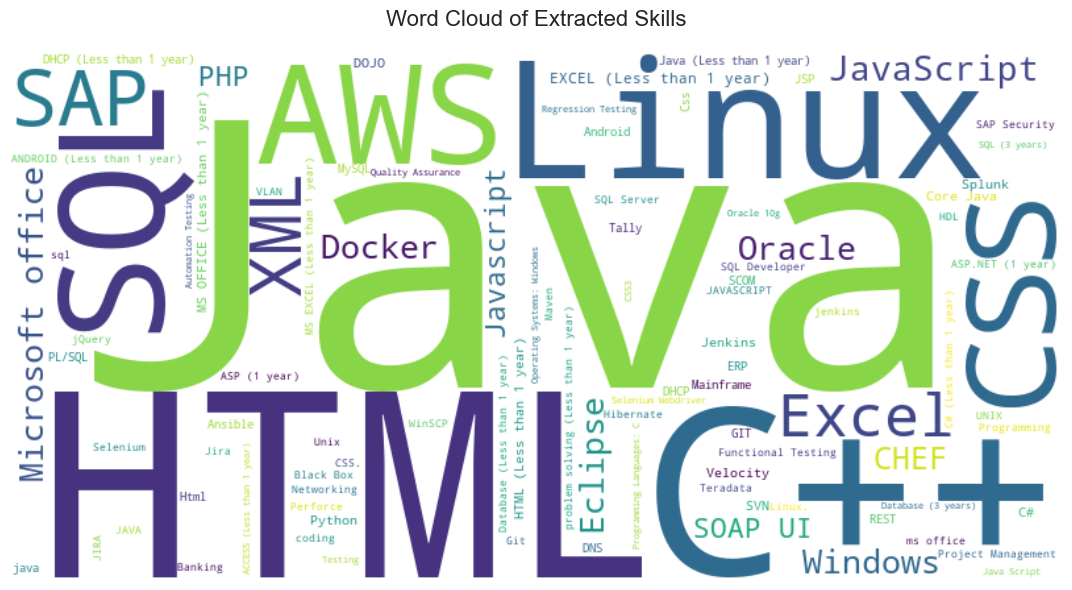

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re


skills = entity_stats['Skills']

all_individual_skills = []
for skill_block in skills:

    individual_skills = skill_block.replace('\n', ' ').replace('•', ',').replace(';', ',').split(',')
    for skill in individual_skills:
        skill_clean = skill.strip()
        if skill_clean and len(skill_clean) > 1:
            all_individual_skills.append(skill_clean)

skill_counter = Counter(all_individual_skills)

def create_skills_wordcloud(skill_counts):
    if skill_counts:

        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='viridis',
            max_words=100
        ).generate_from_frequencies(skill_counts)

        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Extracted Skills', fontsize=16, pad=20)
        plt.tight_layout()
        plt.show()

create_skills_wordcloud(skill_counter)

=== ДЕТАЛЬНЫЙ АНАЛИЗ НАВЫКОВ (SKILLS) ===
Всего блоков навыков: 472
Всего отдельных навыков: 2299
Уникальных навыков: 1800


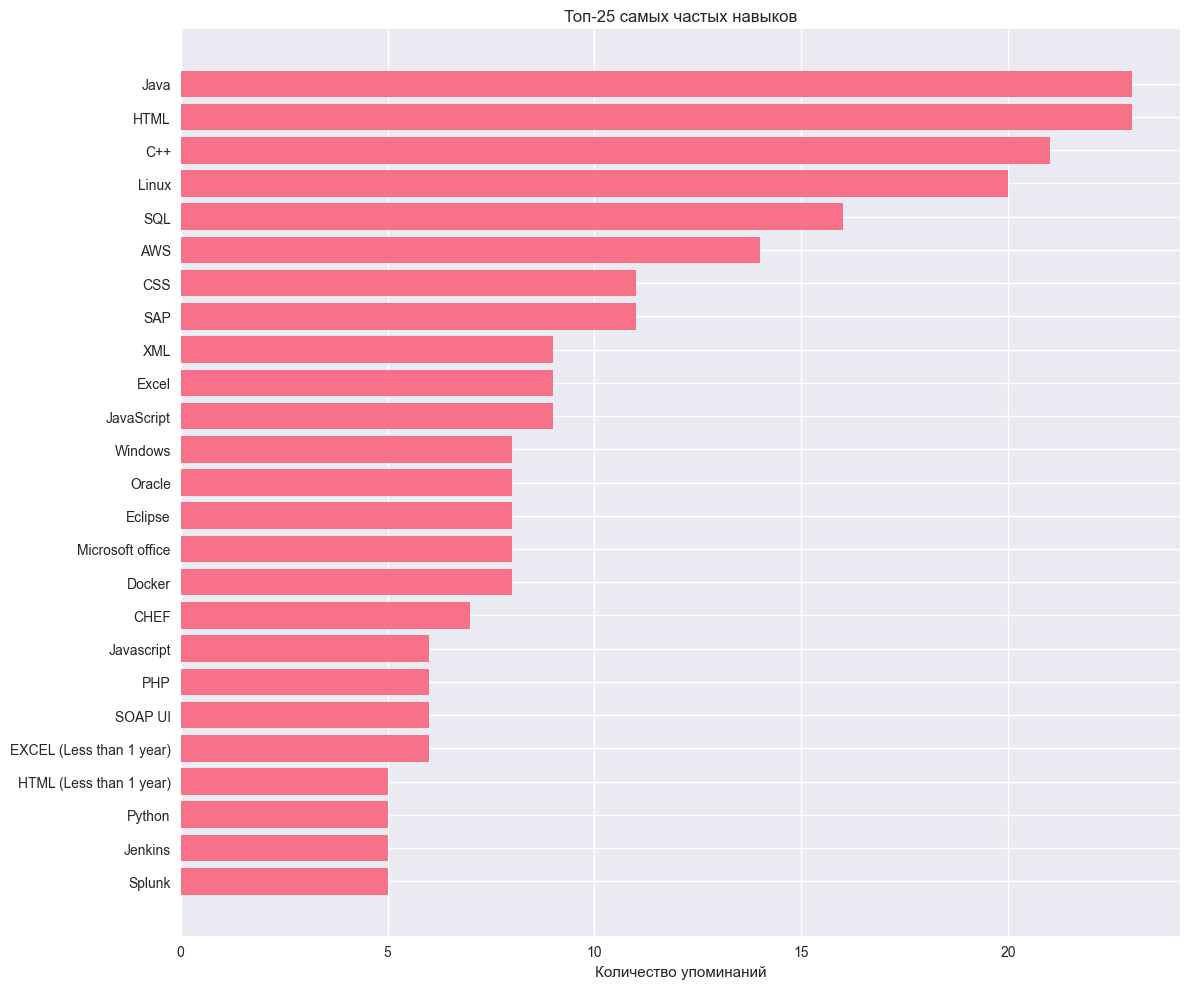


Топ-25 самых частых навыков:
  'Java': 23
  'HTML': 23
  'C++': 21
  'Linux': 20
  'SQL': 16
  'AWS': 14
  'CSS': 11
  'SAP': 11
  'XML': 9
  'Excel': 9
  'JavaScript': 9
  'Windows': 8
  'Oracle': 8
  'Eclipse': 8
  'Microsoft office': 8
  'Docker': 8
  'CHEF': 7
  'Javascript': 6
  'PHP': 6
  'SOAP UI': 6
  'EXCEL (Less than 1 year)': 6
  'HTML (Less than 1 year)': 5
  'Python': 5
  'Jenkins': 5
  'Splunk': 5


In [8]:
print("=== ДЕТАЛЬНЫЙ АНАЛИЗ НАВЫКОВ (SKILLS) ===")


skills = entity_stats['Skills']

all_individual_skills = []
for skill_block in skills:

    individual_skills = skill_block.replace('\n', ' ').replace('•', ',').replace(';', ',').split(',')
    for skill in individual_skills:
        skill_clean = skill.strip()
        if skill_clean and len(skill_clean) > 1:
            all_individual_skills.append(skill_clean)

skill_counter = Counter(all_individual_skills)

print(f"Всего блоков навыков: {len(skills)}")
print(f"Всего отдельных навыков: {len(all_individual_skills)}")
print(f"Уникальных навыков: {len(skill_counter)}")

plt.figure(figsize=(12, 10))
top_skills = dict(skill_counter.most_common(25))
plt.barh(range(len(top_skills)), list(top_skills.values()))
plt.yticks(range(len(top_skills)), list(top_skills.keys()))
plt.title('Топ-25 самых частых навыков')
plt.xlabel('Количество упоминаний')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nТоп-25 самых частых навыков:")
for skill, count in skill_counter.most_common(25):
    print(f"  '{skill}': {count}")

In [9]:
import plotly.express as px
import pandas as pd
import re
from collections import Counter

def create_skills_treemap(entity_stats, top_n=50):
    skills = entity_stats['Skills']

    all_individual_skills = []
    for skill_block in skills:

        individual_skills = skill_block.replace('\n', ' ').replace('•', ',').replace(';', ',').split(',')
        for skill in individual_skills:
            skill_clean = skill.strip()
            if skill_clean and len(skill_clean) > 1:
                all_individual_skills.append(skill_clean)
    
    skill_counts = Counter(all_individual_skills)
    
    skills_df = pd.DataFrame({
        'skill': list(skill_counts.keys()),
        'count': list(skill_counts.values())
    }).sort_values('count', ascending=False).head(top_n)
    
    fig = px.treemap(skills_df,
                    path=['skill'],
                    values='count',
                    title=f'Skills Distribution Treemap (Top {top_n})',
                    color='count',
                    color_continuous_scale='Blues')
    
    fig.update_layout(
        margin=dict(t=50, l=25, r=25, b=25),
        font_size=14
    )
    
    fig.show()
    
    return skills_df

skills_df = create_skills_treemap(entity_stats, top_n=50)

In [10]:
def analyze_companies_and_education(entity_stats):

    if 'Companies worked at' in entity_stats:
        companies = entity_stats['Companies worked at']
        company_counter = Counter(companies)
        print(f"\n=== КОМПАНИИ ===")
        print(f"Всего упоминаний компаний: {len(companies)}")
        print(f"Уникальных компаний: {len(company_counter)}")
        print("\nТоп-15 компаний:")
        for company, count in company_counter.most_common(15):
            print(f"  '{company}': {count}")
    

    if 'College Name' in entity_stats:
        colleges = entity_stats['College Name']
        college_counter = Counter(colleges)
        print(f"\n=== УНИВЕРСИТЕТЫ ===")
        print(f"Всего упоминаний университетов: {len(colleges)}")
        print(f"Уникальных университетов: {len(college_counter)}")
        print("\nТоп-15 университетов:")
        for college, count in college_counter.most_common(15):
            print(f"  '{college}': {count}")
    
    if 'Degree' in entity_stats:
        degrees = entity_stats['Degree']
        degree_counter = Counter(degrees)
        print(f"\n=== СТЕПЕНИ ОБРАЗОВАНИЯ ===")
        print(f"Всего упоминаний степеней: {len(degrees)}")
        print(f"Уникальных степеней: {len(degree_counter)}")
        print("\nТоп-15 степеней:")
        for degree, count in degree_counter.most_common(15):
            print(f"  '{degree}': {count}")

analyze_companies_and_education(entity_stats)


=== КОМПАНИИ ===
Всего упоминаний компаний: 729
Уникальных компаний: 124

Топ-15 компаний:
  'Microsoft': 143
  'Oracle': 116
  'Cisco': 56
  'Infosys Limited': 44
  'Infosys': 35
  'SAP ABAP': 26
  'Accenture': 20
  'Amazon': 19
  'SAP': 13
  'Cisco Systems': 11
  'Oracle Inc': 10
  'Infosys Ltd': 9
  'Microsoft India': 8
  'Oracle Fusion Middleware': 8
  'SAP Basis': 8

=== УНИВЕРСИТЕТЫ ===
Всего упоминаний университетов: 330
Уникальных университетов: 283

Топ-15 университетов:
  'Osmania University': 6
  'Anna University': 5
  'Visvesvaraya Technological University': 4
  'Nagarjuna University': 4
  'Manipal University': 3
  'CDAC': 3
  'Vivekananda Engineering College for Women': 3
  'Periyar University': 3
  'Mumbai University': 2
  'Berhampur university': 2
  'R.D.H.S. School': 2
  'Crescent Public School -  New Delhi, Delhi': 2
  'Saurashtra University': 2
  'Rashtriya Military School Bangalore': 2
  'Lovely Public Sr. Sec. School': 2

=== СТЕПЕНИ ОБРАЗОВАНИЯ ===
Всего упоминани


=== МЕСТОПОЛОЖЕНИЯ ===
Всего упоминаний местоположений: 430
Уникальных местоположений: 83


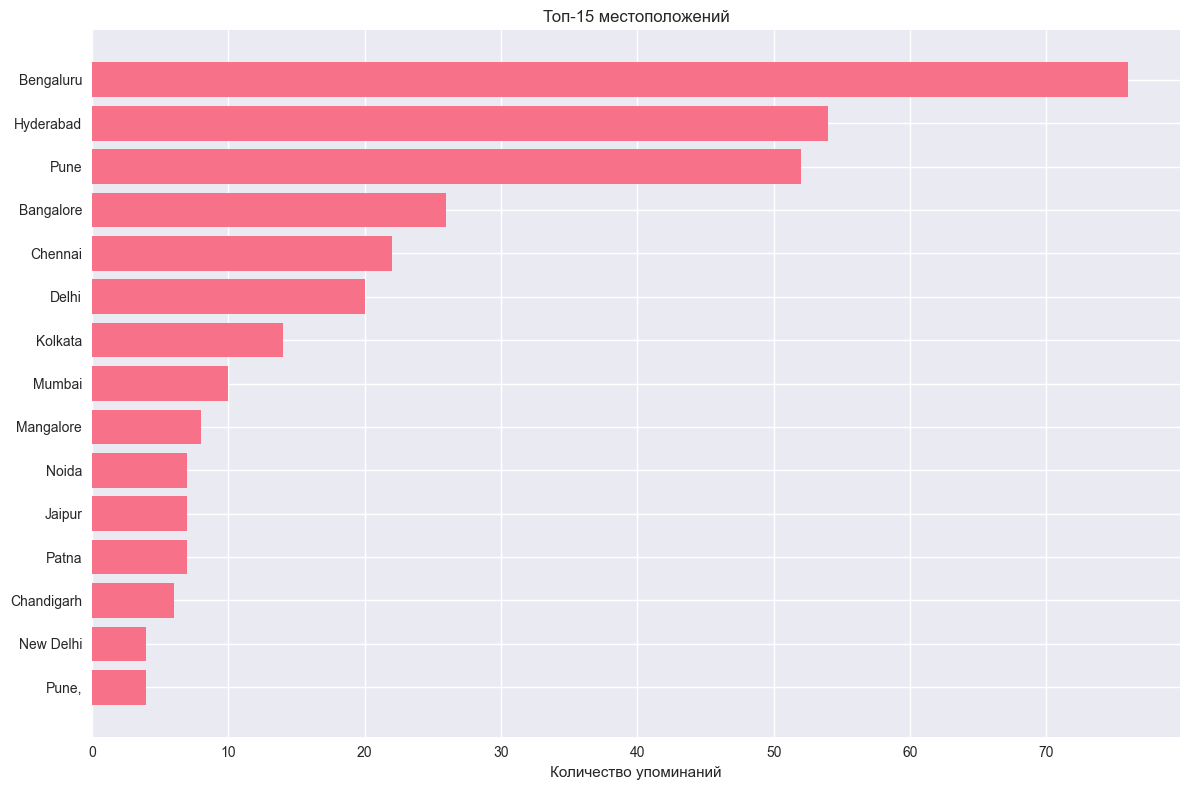


=== EMAIL АДРЕСА ===
Всего email адресов: 252


In [11]:
def analyze_locations_and_emails(entity_stats):

    if 'Location' in entity_stats:
        locations = entity_stats['Location']
        location_counter = Counter(locations)
        print(f"\n=== МЕСТОПОЛОЖЕНИЯ ===")
        print(f"Всего упоминаний местоположений: {len(locations)}")
        print(f"Уникальных местоположений: {len(location_counter)}")
        
        plt.figure(figsize=(12, 8))
        top_locations = dict(location_counter.most_common(15))
        plt.barh(range(len(top_locations)), list(top_locations.values()))
        plt.yticks(range(len(top_locations)), list(top_locations.keys()))
        plt.title('Топ-15 местоположений')
        plt.xlabel('Количество упоминаний')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    if 'Email Address' in entity_stats:
        emails = entity_stats['Email Address']
        print(f"\n=== EMAIL АДРЕСА ===")
        print(f"Всего email адресов: {len(emails)}")
        

analyze_locations_and_emails(entity_stats)

In [12]:
print("="*60)
print("ИТОГОВЫЙ ОТЧЕТ EDA АНАЛИЗА RESUME ENTITIES DATASET")
print("="*60)

print(f"\n ОБЩАЯ СТАТИСТИКА:")
print(f"   • Всего резюме: {len(resumes_data)}")
print(f"   • Всего аннотированных сущностей: {len(entities_df):,}")
print(f"   • Уникальных типов сущностей: {entities_df['label'].nunique()}")
print(f"   • Среднее количество сущностей на резюме: {np.mean(entities_per_resume):.1f}")

print(f"\n  ТОП-5 ТИПОВ СУЩНОСТЕЙ:")
top_5_labels = entities_df['label'].value_counts().head(5)
for i, (label, count) in enumerate(top_5_labels.items(), 1):
    percentage = (count / len(entities_df)) * 100
    print(f"   {i}. {label}: {count:,} ({percentage:.1f}%)")

print(f"\n СТАТИСТИКА ПО ДЛИНЕ:")
print(f"   • Средняя длина сущности: {entities_df['length'].mean():.1f} символов")
print(f"   • Медианная длина: {entities_df['length'].median():.1f} символов")
print(f"   • Минимальная длина: {entities_df['length'].min()} символов")
print(f"   • Максимальная длина: {entities_df['length'].max()} символов")

print(f"\n ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:")
print(f"   • Всего уникальных текстов сущностей: {entities_df['text'].nunique():,}")
print(f"   • Процент уникальных сущностей: {entities_df['text'].nunique()/len(entities_df)*100:.1f}%")
print(f"   • Стандартное отклонение длины: {entities_df['length'].std():.1f}")

longest_entities = entities_df.nlargest(3, 'length')[['label', 'text', 'length']]
print(f"\n САМЫЕ ДЛИННЫЕ СУЩНОСТИ:")
for _, entity in longest_entities.iterrows():
    text_preview = entity['text'][:100] + "..." if len(entity['text']) > 100 else entity['text']
    print(f"   • {entity['label']} ({entity['length']} chars): {text_preview}")


ИТОГОВЫЙ ОТЧЕТ EDA АНАЛИЗА RESUME ENTITIES DATASET

 ОБЩАЯ СТАТИСТИКА:
   • Всего резюме: 220
   • Всего аннотированных сущностей: 3,556
   • Уникальных типов сущностей: 11
   • Среднее количество сущностей на резюме: 16.2

  ТОП-5 ТИПОВ СУЩНОСТЕЙ:
   1. Companies worked at: 729 (20.5%)
   2. Designation: 521 (14.7%)
   3. Skills: 472 (13.3%)
   4. Location: 430 (12.1%)
   5. College Name: 330 (9.3%)

 СТАТИСТИКА ПО ДЛИНЕ:
   • Средняя длина сущности: 29.9 символов
   • Медианная длина: 13.0 символов
   • Минимальная длина: 1 символов
   • Максимальная длина: 2473 символов

 ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:
   • Всего уникальных текстов сущностей: 1,745
   • Процент уникальных сущностей: 49.1%
   • Стандартное отклонение длины: 85.9

 САМЫЕ ДЛИННЫЕ СУЩНОСТИ:
   • Skills (2473 chars): side debugging.
• Hands on experience of Visual Studio debugger for debugging on Windows
platform.
•...
   • Skills (1567 chars): Uft/qtp,alm/qc,jira,jenkins,automation testing,cicd,service vitualization,uipath
